In [255]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [276]:
# copied from https://github.com/scikit-learn/scikit-learn/blob/b568f203ede7869ecbc6b1a3f7ec5b35868c96d1/sklearn/metrics/_plot/confusion_matrix.py#L127
class ConfusionMatrixDisplay:
    """Confusion Matrix visualization.
    It is recommend to use :func:`~sklearn.metrics.plot_confusion_matrix` to
    create a :class:`ConfusionMatrixDisplay`. All parameters are stored as
    attributes.
    Read more in the :ref:`User Guide <visualizations>`.
    Parameters
    ----------
    confusion_matrix : ndarray of shape (n_classes, n_classes)
        Confusion matrix.
    display_labels : ndarray of shape (n_classes,)
        Display labels for plot.
    Attributes
    ----------
    im_ : matplotlib AxesImage
        Image representing the confusion matrix.
    text_ : ndarray of shape (n_classes, n_classes), dtype=matplotlib Text, \
            or None
        Array of matplotlib axes. `None` if `include_values` is false.
    ax_ : matplotlib Axes
        Axes with confusion matrix.
    figure_ : matplotlib Figure
        Figure containing the confusion matrix.
    """
    def __init__(self, confusion_matrix, display_labels):
        self.confusion_matrix = confusion_matrix
        self.display_labels = display_labels

    def plot(self, include_values=True, cmap='viridis',
             xticks_rotation='horizontal', values_format=None, ax=None, title=None):
        """Plot visualization.
        Parameters
        ----------
        include_values : bool, default=True
            Includes values in confusion matrix.
        cmap : str or matplotlib Colormap, default='viridis'
            Colormap recognized by matplotlib.
        xticks_rotation : {'vertical', 'horizontal'} or float, \
                         default='horizontal'
            Rotation of xtick labels.
        values_format : str, default=None
            Format specification for values in confusion matrix. If `None`,
            the format specification is 'd' or '.2g' whichever is shorter.
        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.
        title : title str to display
        Returns
        -------
        display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
        """
        #check_matplotlib_support("ConfusionMatrixDisplay.plot")
        import matplotlib.pyplot as plt
        import matplotlib.colors as mc
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure

        cm = self.confusion_matrix
        n_classes = cm.shape[0]
        self.im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap, norm=mc.Normalize(vmin=0))
        self.text_ = None
        cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(256)

        if include_values:
            self.text_ = np.empty_like(cm, dtype=object)

            # print text with appropriate color depending on background
            thresh = (cm.max() + cm.min()) / 2.0

            for i, j in product(range(n_classes), range(n_classes)):
                color = cmap_max if cm[i, j] < thresh else cmap_min

                if values_format is None:
                    text_cm = format(cm[i, j], '.2g')
                    if cm.dtype.kind != 'f':
                        text_d = format(cm[i, j], 'd')
                        if len(text_d) < len(text_cm):
                            text_cm = text_d
                else:
                    text_cm = format(cm[i, j], values_format)

                self.text_[i, j] = ax.text(
                    j, i, text_cm,
                    ha="center", va="center",
                    color=color)
        
        plt.title(title, size=20)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2.5%", pad=0.05)
        fig.colorbar(self.im_, ax=ax, cax=cax, format='%0.2f')
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=self.display_labels,
               yticklabels=self.display_labels,
               ylabel="True class",
               xlabel="Predicted class")

        ax.set_ylim((n_classes - 0.5, -0.5))
        plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)
        plt.tight_layout()

        self.figure_ = fig
        self.ax_ = ax
        return self

In [277]:
def plot_cm(path, path_data_stats, class_range=[25, 123], outname=None):
    with open(path, "rb") as fp:
        results_dict = pickle.load(fp)
    with open(dataset_stats_path, "rb") as fp:
        dataset_stats_dict = pickle.load(fp)
        stats = dataset_stats_dict['stats']

    num_per_class = results_dict['cm'].sum(axis=0).reshape(1, -1)
    results_dict['normalized_cm'] = results_dict['cm'] / (num_per_class  + 1e-8)
    #if display_labels is None:
    #display_labels = range(results_dict['cm'].shape[0])
    
    start = class_range[0]
    end = class_range[1]
    disp = ConfusionMatrixDisplay(confusion_matrix=results_dict['normalized_cm'][start:end, start:end], 
                                  display_labels=list(stats.keys())[start:end])

    f, ax = plt.subplots(figsize=(18,18))

    title = 'mean per-class accuracy: {:.3f}, top1/5 acc: {:.2f}/{:.2f}'.format(results_dict['mean_class_accuracy'], 
                                                                                  results_dict['topk']['top1_acc'],
                                                                                  results_dict['topk']['top5_acc'])
    disp.plot(include_values=False, cmap='viridis', ax=ax, xticks_rotation='vertical', values_format=None, title=title)
    if outname is not None:
        disp.figure_.savefig(outname, dpi=150)

In [280]:
def plot_data_stats(dataset_stats_path):
    with open(dataset_stats_path, "rb") as fp:
        dataset_stats_dict = pickle.load(fp)
        stats = dataset_stats_dict['stats']
        train_stats = dataset_stats_dict['train_stats']
        test_stats = dataset_stats_dict['test_stats']
    class_list = stats.keys()
    plt.figure(figsize=(18, 6))
    plt.plot(range(0, len(class_list)), list(train_stats.values()), 'k-', label='train', alpha=0.75)
    plt.plot(range(0, len(class_list)), list(test_stats.values()), 'b--', label='test', alpha=0.75)
    plt.ylabel('# of samples per class', fontsize=16)
    plt.xticks(range(0, len(class_list)), stats.keys(), rotation=90)
    plt.grid()
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig('datastats.png', dpi=150)
    plt.show()
            
def plot_perclass_acc(dataset_stats_path, list_metric_paths, names):
    from matplotlib.pyplot import cm
    num_methods = len(list_metric_paths)
    color=cm.rainbow(np.linspace(0, 1, num_methods))
    
    with open(dataset_stats_path, "rb") as fp:
        dataset_stats_dict = pickle.load(fp)
        stats = dataset_stats_dict['stats']
        train_stats = dataset_stats_dict['train_stats']
        test_stats = dataset_stats_dict['test_stats']
        
    plt.figure()
    for i in range(num_methods):
        with open(list_metric_paths[i], "rb") as fp:
            results_dict = pickle.load(fp)

        label = names[i]
        if i == 0:
            class_list = stats.keys()
            fig, ax1 = plt.subplots(figsize=(20, 8))
            plt.title('per-class accuracies', fontsize=16)
            ax1.set_xlabel('class', fontsize=16)
            ax1.set_ylabel('accuracy', color='b', fontsize=16)
            
            plt.plot(range(0, len(class_list)), list(results_dict['per_class_accuracies'].values()), 'o-', c=color[i], label=label)
            
        else:
            plt.plot(range(0, len(class_list)), list(results_dict['per_class_accuracies'].values()), 'o-', c=color[i], label=label)
    plt.grid()
    plt.plot([0], [0], 'k--', alpha=0.35, label='# of training samples')
    plt.legend(fontsize=16)
    plt.xticks(range(0, len(class_list)), stats.keys(), rotation=90)
    ax2 = ax1.twinx()
    ax2.set_ylabel('number of training samples', color='k', fontsize=16)
    plt.plot(range(0, len(class_list)), list(train_stats.values()), 'k--', alpha=0.35)
    
    fig.tight_layout()
    plt.savefig('perclass_acc.png', dpi=150)
    plt.show()

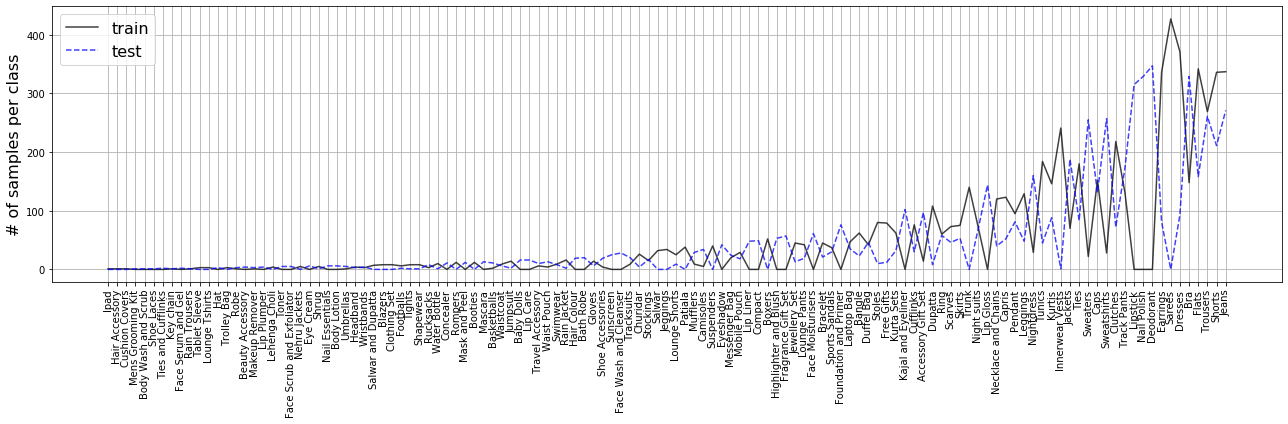

In [259]:
plot_data_stats('data_stats.pkl')

<Figure size 432x288 with 0 Axes>

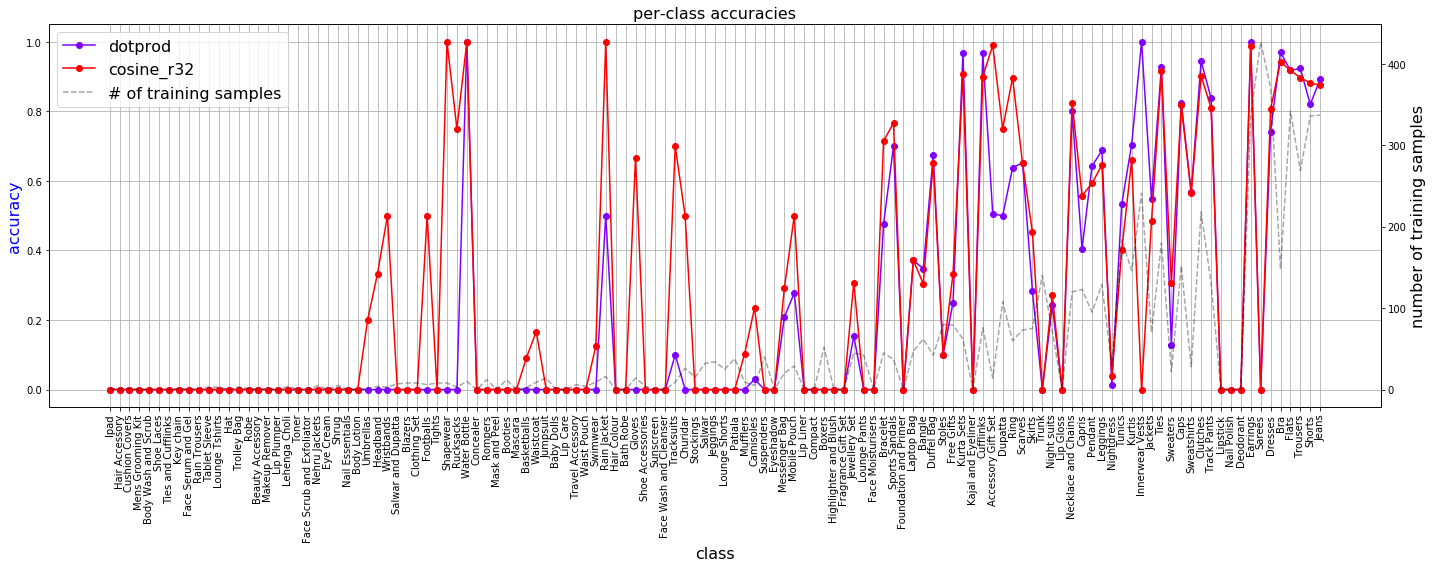

In [281]:
dataset_stats_path = 'data_stats.pkl'
list_metric_paths = ['../checkpoints/res50_finetune/metrics.pkl',
                    '../checkpoints/res50_normw_normx_finetune_r32/metrics.pkl']
names = ['dotprod', 'cosine_r32']
plot_perclass_acc(dataset_stats_path, list_metric_paths, names)

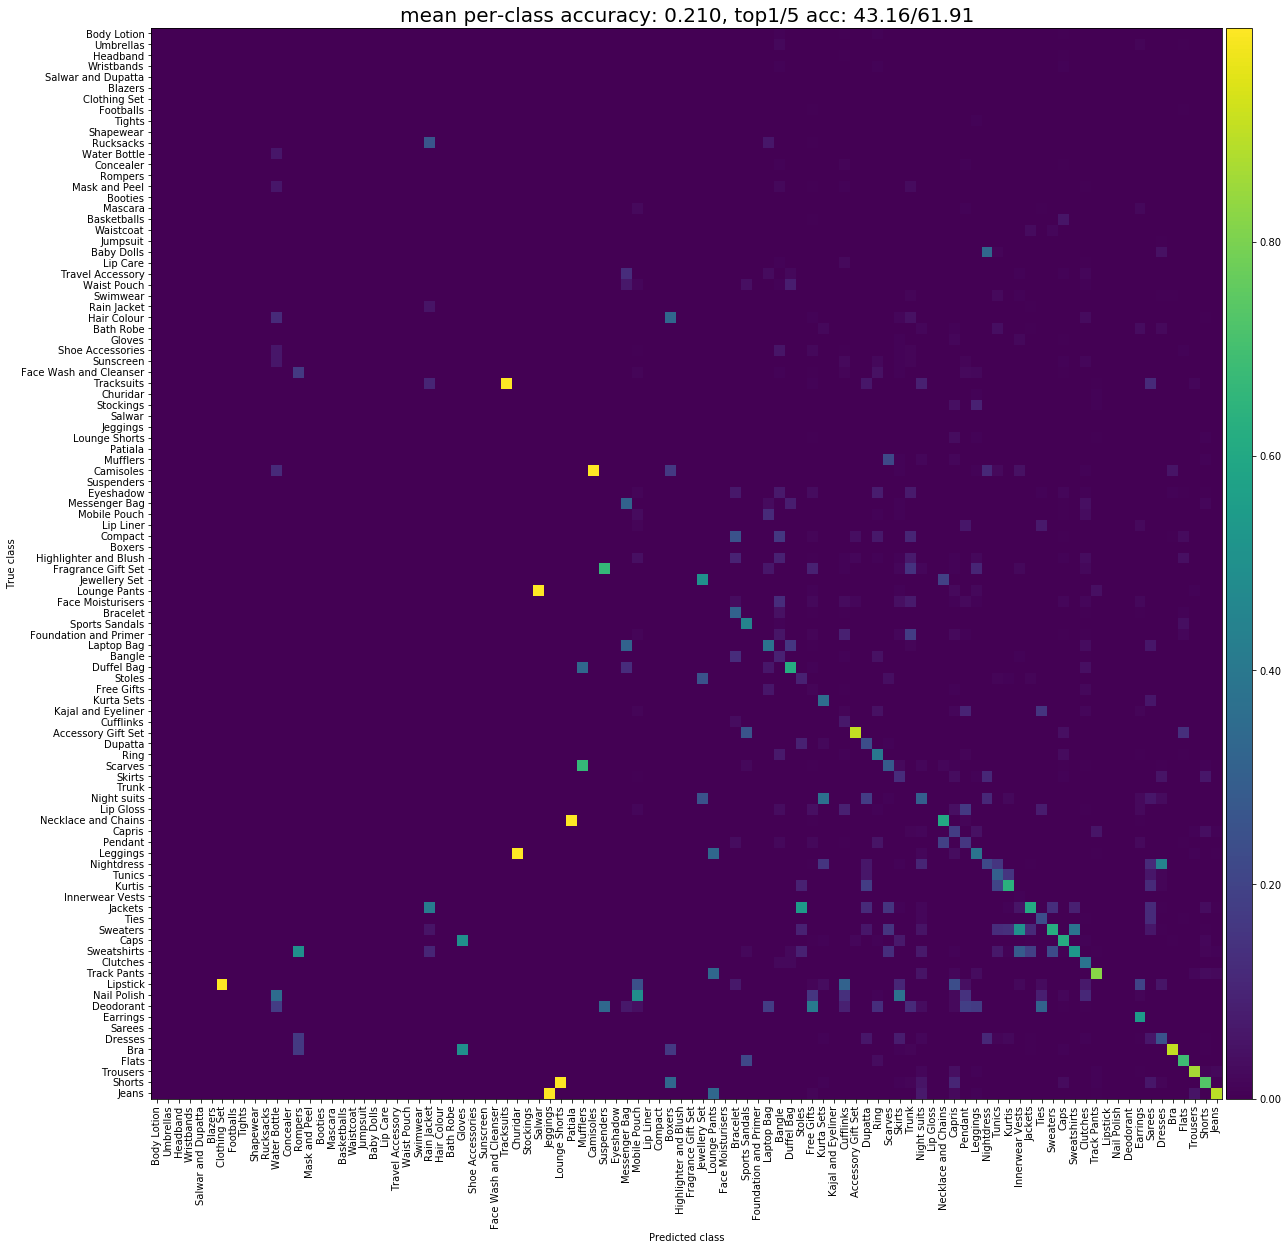

In [278]:
path_to_results = '../checkpoints/res50_finetune/metrics.pkl'
dataset_stats_path = 'data_stats.pkl'
plot_cm(path_to_results, dataset_stats_path, outname='res50_finetune_cm.png')

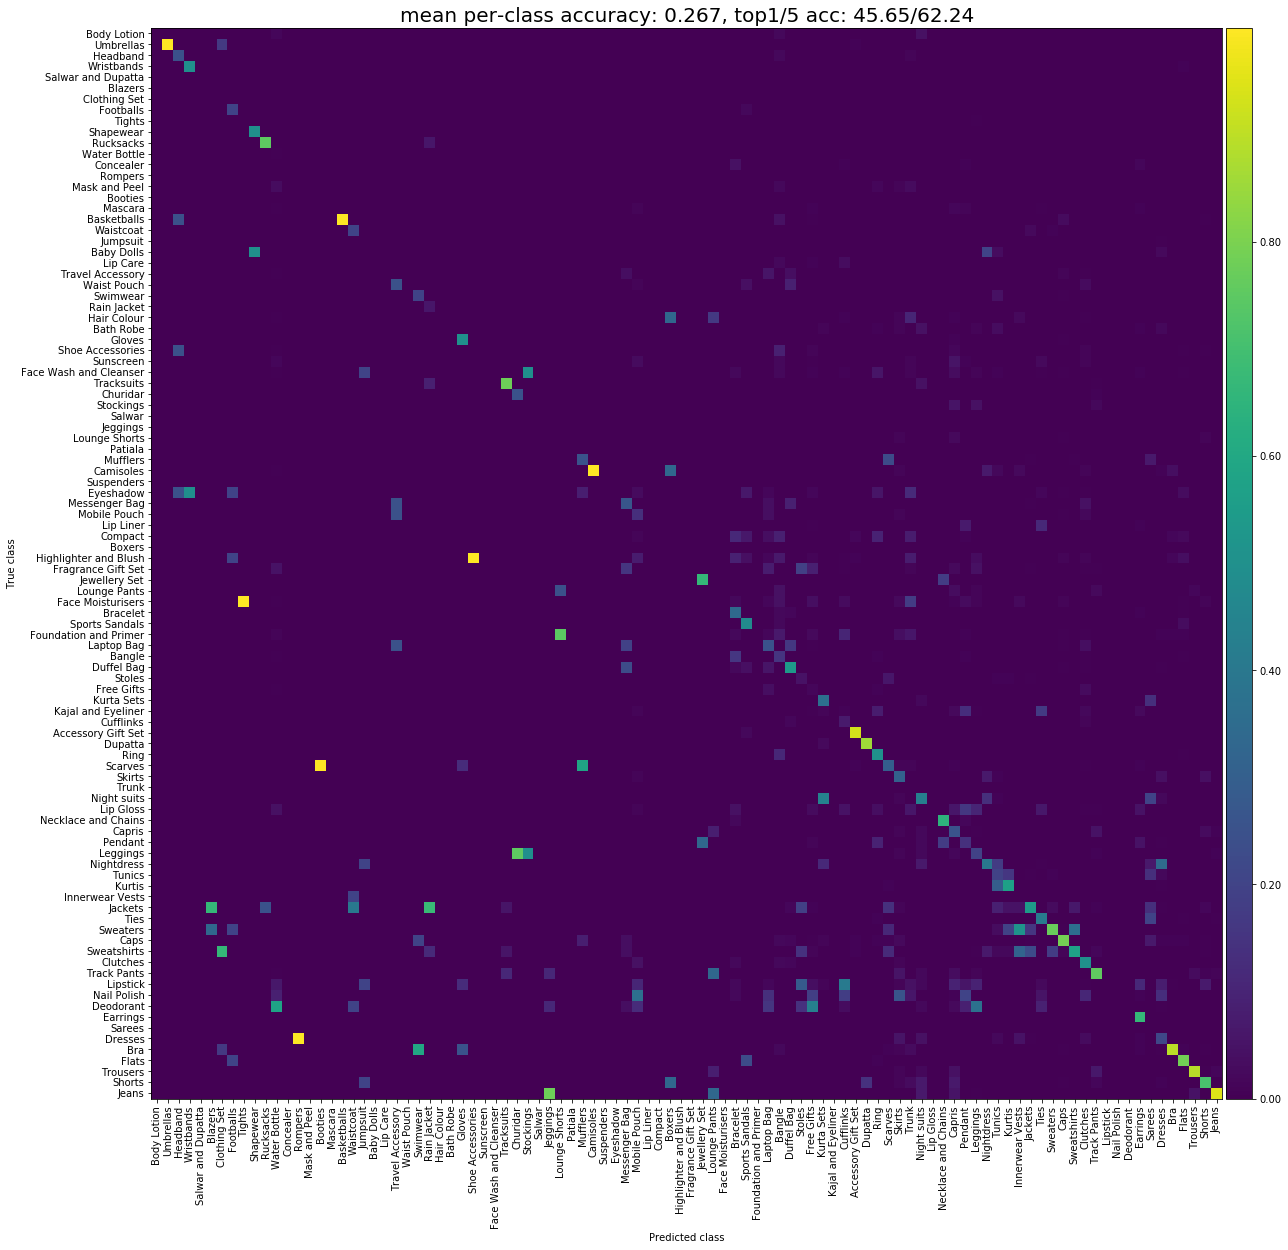

In [279]:
path_to_results = '../checkpoints/res50_normw_normx_finetune_r32/metrics.pkl'
plot_cm(path_to_results, dataset_stats_path, outname='res50_normw_normx_finetune_r32_cm.png')

In [252]:
def plot_data_stats_and_norms(dataset_stats_path, path_to_norm):
    with open(dataset_stats_path, "rb") as fp:
        dataset_stats_dict = pickle.load(fp)
        stats = dataset_stats_dict['stats']
        train_stats = dataset_stats_dict['train_stats']
        test_stats = dataset_stats_dict['test_stats']
    with open(path_to_norm, "rb") as fp:
        norm_dict = pickle.load(fp)
        weight_norm = norm_dict['w_norm']
    
    class_list = stats.keys()
    fig, ax1 = plt.subplots(figsize=(18, 8))
    plt.plot(range(0, len(class_list)), list(train_stats.values()), 'k-', label='train', alpha=0.75)
    #plt.plot(range(0, len(class_list)), list(test_stats.values()), 'b--', label='test', alpha=0.75)
    plt.plot([0], [0], 'b-.', label='class weight norm', alpha=0.75)
    ax1.set_ylabel('# of samples per class', fontsize=16)
    plt.xticks(range(0, len(class_list)), stats.keys(), rotation=90)
    plt.legend(fontsize=16)
    plt.grid()
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('weight norm', color='k', fontsize=16)
    plt.plot(range(0, len(class_list)), weight_norm, 'b-.', alpha=0.75)
    plt.tight_layout()
    plt.savefig('weight_norm.png', dpi=150)
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.plot(list(train_stats.values()), weight_norm, 'bo', alpha=0.75)
    plt.xlabel('# of training samples per class', fontsize=16)
    plt.ylabel("norm of classifier's weight", fontsize=16)
    plt.savefig('weight_norm2.png', dpi=150)
    plt.show()

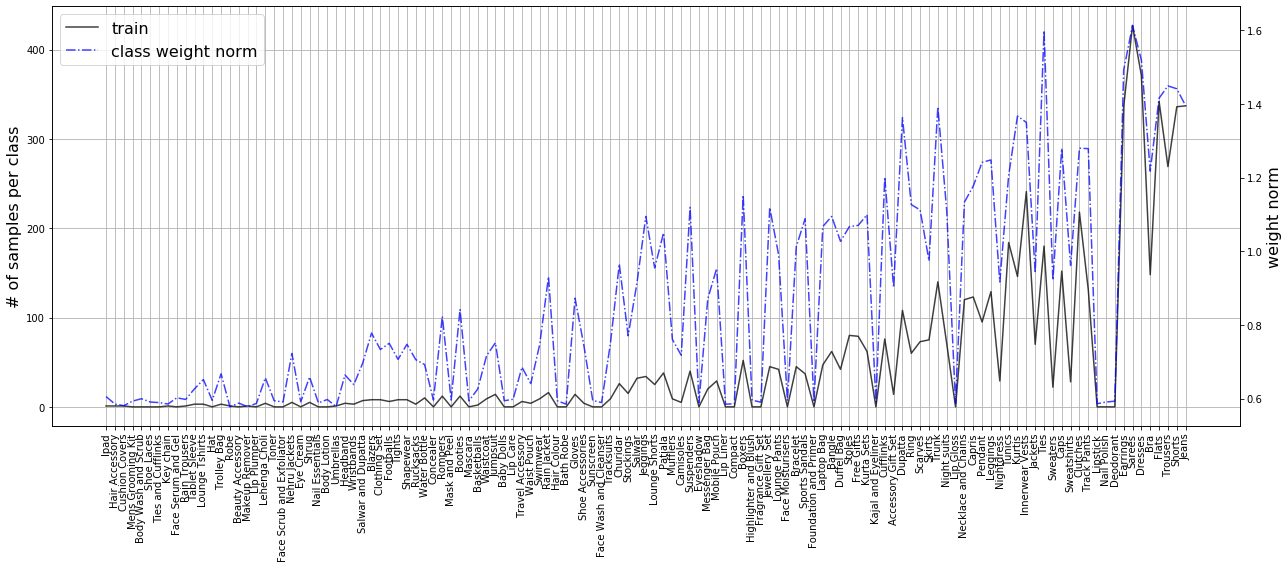

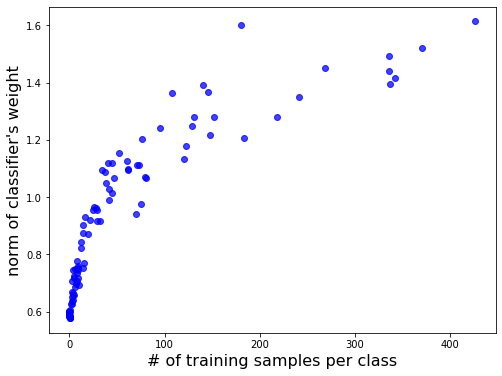

In [253]:
path = 'norm.pkl'
dataset_stats_path = 'data_stats.pkl'
plot_data_stats_and_norms(dataset_stats_path, path)